In [1]:
import time
import torch
import math
import pandas as pd
import numpy as np
import arviz as az
import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')


from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath, GeodesicProbPath
from flow_matching.solver import Solver, ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
import math
import torch
from torch.utils.data import Dataset, DataLoader
from sbmfi.priors.mog import MixtureOfGaussians

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from PolyRound.api import Polytope
from sbmfi.inference.manifolds import BallManifold, Manifold, ConvexPolytopeManifold
from sbmfi.core.coordinater import *
from sbmfi.core.linalg import LinAlg
from sbmfi.inference.arxiv_polytope_plotter import plot_dataframes
from sbmfi.inference.pol_flow_match import *

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.set_default_dtype(torch.float)
torch.manual_seed(42)

Using gpu


In [3]:
fcm, v_representation, pol_volume = pickle.load(open('spiro_flux_coordinate_mapper.p', 'rb'))
psm = fcm.sampler

### Prepare all the data

In [6]:
data = az.from_netcdf('mog_polytope_105k_samples.nc')
mog_rounded = torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
mog_target = MixtureOfGaussians(
    means=torch.as_tensor(data.attrs['mog_means'], dtype=torch.float), 
    covariances=torch.as_tensor(data.attrs['mog_covs'], dtype=torch.float),
    weights=torch.as_tensor(data.attrs['mog_weights'], dtype=torch.float),
)
means_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=psm.rounded_id.append(pd.Index(['weights']))
)
mog_Z = data.attrs['mog_Z']
del data

In [4]:
data = az.from_netcdf('Kmog_polytope_105k_samples.nc')
A_cols = [v[2:] for v in data.posterior.theta_id.values]
Kpol = Polytope(
    A=pd.DataFrame(data.attrs['A'], columns=A_cols),
    b=pd.Series(data.attrs['b']),
)
Kpsm = PolytopeSamplingModel(Kpol, linalg=LinAlg(backend='torch'))
Kmeans_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=Kpsm.rounded_id.append(pd.Index(['weights']))
)
Kmog_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
del data

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-27


In [5]:
data = az.from_netcdf('unif_polytope_125k_samples.nc')
unif_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
del data

In [7]:
data = az.from_netcdf('Kunif_polytope_125k_samples.nc')
Kunif_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
del data

### Functions

In [10]:


torch_linalg = LinAlg(backend='torch', device=device, dtype=np.float32)
def sample_ball(shape):
    return torch_linalg.sample_unit_hyper_sphere_ball(shape, ball=True)   

In [8]:
def train_affine(model, optimizer, noise_dataloader, target_dataloader, losses):
    n_steps = n_epochs * len(noise_dataloader)
    pbar = tqdm.tqdm(total=n_steps, ncols=120, position=0)
    start_time = time.time()
    try:
        for epoch in range(n_epochs):
            # use fixed data-set
            noise_iter = iter(noise_dataloader)
            target_iter = iter(target_dataloader)
            
            for i in range(len(noise_dataloader)): 
                optimizer.zero_grad() 
    
                target_chunk = next(target_iter, None)[0]
                noise_chunk = next(noise_iter, None)[0]
        
                t = torch.rand(noise_chunk.shape[0]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=noise_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')
        
                loss_ = loss.item()
                losses.append(loss_)
                pbar.update()
                pbar.set_postfix(loss=round(loss_, 4))
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()

### Affine flow

In [184]:
# training arguments
lr = 1e-3
n_epochs = 50
batch_size = 1024*8
hidden_dim = 512

# velocity field model init
aff_model = MLP(input_dim=mog_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(aff_model.parameters(), lr=lr) 
scheduler = None

test_size = 20000

noise_dataset = torch.utils.data.TensorDataset(unif_rounded.to(dtype=torch.float, device=device))
test_dataset, noise_dataset = torch.utils.data.random_split(noise_dataset, [test_size, len(noise_dataset) - test_size])
noise_dataloader = torch.utils.data.DataLoader(noise_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

target_dataset = torch.utils.data.TensorDataset(mog_rounded[:-test_size].to(dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

losses = []

In [185]:
# train_affine(aff_model, optimizer, noise_dataloader, target_dataloader, losses)
# torch.save(aff_model.state_dict(), "aff_model.pt")
# pickle.dump(losses, open('aff_losses.p', 'wb'))
aff_model.load_state_dict(torch.load("aff_model.pt"))
losses = pickle.load(open('aff_losses.p', 'rb'))

C:\Users\diede\AppData\Local\Temp\ipykernel_14988\1630021361.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aff_model.load_state_dict(torch.load("aff_model.pt"))


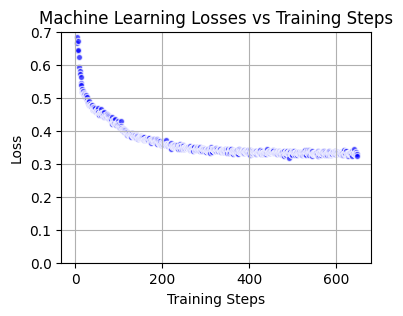

In [186]:
fig = plot_losses_vs_steps(losses)
plt.show()

In [187]:
wrapped_vf = WrappedModel(aff_model)

x_init = test_dataset[:][0].to(dtype=torch.float, device=device)
solver = ODESolver(velocity_model=wrapped_vf)

In [188]:
log_pol_vol = np.log(pol_volume)
def log_p_pol(values):
    return torch.full(values.shape[:-1], -log_pol_vol, dtype=values.dtype, device=values.device)

In [189]:
sol, log_det = sample_and_div(
    ode_solver=solver,
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates = False,
    return_div= True,
    exact_divergence=True,
)

log_q0 = log_p_pol(x_init)
log_q = log_q0 - log_det
flow_numpy = sol.to(device='cpu', dtype=torch.double)


In [190]:
# sol2 = solver.sample(
#     x_init=x_init,
#     method='midpoint',
#     step_size=0.05,
#     return_intermediates=False,
# )  # sample from the model

# _, log_q2 = solver.compute_likelihood(
#     x_1=sol2,
#     method='midpoint',
#     step_size=0.05, 
#     exact_divergence=True,
#     log_p0=log_p_pol,
#     return_intermediates=True
# )
# #  log_q2 is almost equal to log_q from the cell above!

In [196]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=pd.DataFrame(flow_numpy, columns=psm.rounded_id),
    n_sample_cdf=10000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

In [198]:
# plt.savefig(
#     'affine_flow.svg', transparent=None, dpi='figure', format='svg',
#     metadata=None, bbox_inches=None, pad_inches=0.1,
#     facecolor='auto', edgecolor='auto', backend=None,
# )

In [89]:
in_pol = ((psm._G @ flow_numpy.T) < psm._h).all(0)
in_pol = in_pol.sum()

weights_df = pd.DataFrame([
    (mog_target.log_prob(sol.to('cpu')) - log_pol_vol).numpy(),
    log_q.to('cpu').numpy()[0,:],
], index=['log_p', 'log_q']).T

weights_df['diff'] = weights_df['log_p'] - weights_df['log_q']

ws = np.exp(weights_df['diff'])
KL_Z = ws.mean()
ln_KL = (weights_df['log_p'] + weights_df['log_q']).mean() + np.log(KL_Z)
KL = np.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()
print(f'ESS: {round(ESS, 3)}, KL div.: {round(KL,8)}, in pol: {in_pol}')

ESS: 17842.745, KL div.: 0.000563020003028214, in pol: 19159


In [224]:
(20000 - 19159) / 20000

0.04205

In [223]:
17842.74 / 20000

0.8921370000000001

### Higher dimensions

In [3]:
data = az.from_netcdf('Kunif_polytope_125k_samples.nc')
Kunif_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values
).T
del data

In [4]:
lr = 1e-3
n_epochs = 50
batch_size = 1024*8
hidden_dim = 1024
test_size = 20000

# velocity field model init
Kaff_model = MLP(input_dim=Kunif_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim, hidden_layers=6).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(Kaff_model.parameters(), lr=lr) 
scheduler = None

# target_dataset = torch.utils.data.TensorDataset(Kmog_rounded.to(dtype=torch.float, device=device))
# target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

noise_dataset = torch.utils.data.TensorDataset(Kunif_rounded.to(dtype=torch.float, device=device))
test_dataset, noise_dataset = torch.utils.data.random_split(noise_dataset, [test_size, len(noise_dataset) - test_size])
noise_dataloader = torch.utils.data.DataLoader(noise_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
del noise_dataloader, noise_dataset

losses = []

In [5]:
# train_affine(Kaff_model, optimizer, noise_dataloader, target_dataloader, losses)
# torch.save(Kaff_model.state_dict(), "Kaff_model.pt")
# pickle.dump(losses, open('Kaff_model_1024_losses.p', 'wb'))
KKaff_model = MLP(input_dim=Kunif_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim, hidden_layers=6).to(device) 
KKaff_model.load_state_dict(torch.load("Kaff_model.pt"))


C:\Users\diede\AppData\Local\Temp\ipykernel_21340\1983946936.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  KKaff_model.load_state_dict(torch.load("Kaff_model.pt"))


<All keys matched successfully>

In [6]:
wrapped_vf = WrappedModel(KKaff_model)

step_size = torch.Tensor([0.05]).to(device=device, dtype=torch.float)

x_init = test_dataset[:][0].to(dtype=torch.float, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
# sol = solver.sample(
#     time_grid=torch.Tensor([0.0, 1.0]).to(dtype=torch.float, device=device), 
#     x_init=x_init,
#     method='midpoint',
#     step_size=step_size,
#     return_intermediates=True,
# )  # sample from the model

In [20]:
sols = []
log_dets = []
test_loader = torch.utils.data.DataLoader(x_init, batch_size=1500)

# for i, batch in enumerate(test_loader):
#     sol, log_det = sample_and_div(
#         ode_solver=solver,
#         x_init=batch,
#         step_size=0.05,
#         method= "midpoint",
#         return_intermediates = False,
#         return_div= True,
#         exact_divergence=True,
#     )
#     sols.append(sol.detach())
#     log_dets.append(log_det.detach())
# pickle.dump((torch.cat(sols).to('cpu'), torch.cat(log_dets, 1).to('cpu')), open('Kflow_sols_log_dets.p', 'wb'))
sol, log_det = pickle.load(open('Kflow_sols_log_dets.p', 'rb'))

In [21]:
sol, log_det = pickle.load(open('Kflow_sols_log_dets.p', 'rb'))

In [22]:
log_q0 = log_p_pol(x_init)
log_q = log_q0 - log_det
flow_numpy = sol.to(device='cpu', dtype=torch.double)

NameError: name 'log_p_pol' is not defined

In [ ]:
flow_numpy = sol.to(device='cpu', dtype=torch.double)
in_pol = ((Kpsm._G @ flow_numpy[1].T) < Kpsm._h).all(0)

in_pol.sum()

In [ ]:
in_pol = ((Kpsm._G @ flow_numpy.T) < Kpsm._h).all(0)
in_pol = in_pol.sum()

weights_df = pd.DataFrame([
    (mog_target.log_prob(sol.to('cpu')) - log_pol_vol).numpy(),
    log_q.to('cpu').numpy()[0,:],
], index=['log_p', 'log_q']).T

weights_df['diff'] = weights_df['log_p'] - weights_df['log_q']

ws = np.exp(weights_df['diff'])
KL_Z = ws.mean()
ln_KL = (weights_df['log_p'] + weights_df['log_q']).mean() + np.log(KL_Z)
KL = np.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()
print(f'ESS: {round(ESS, 3)}, KL div.: {round(KL,8)}, in pol: {in_pol}')

In [217]:
import itertools
Kv_representation = pd.DataFrame(np.array(list(itertools.product([-1, 1], repeat=20))), columns=Kpsm.rounded_id)

In [220]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=Kv_representation,
    samples=pd.DataFrame(flow_numpy[1], columns=Kpsm.rounded_id),
    n_sample_cdf=1000,
    points=Kmeans_df,
    x_col='R_fki', 
    y_col='R_bfn',
    x_label='R_fki', 
    y_label='R_bfn',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

In [221]:
plt.savefig(
    'Kaffine_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)

### Riemannian flows

In [4]:
def train_riemann(model, optimizer, dataloader, losses):
    n_steps = n_epochs * len(dataloader)
    pbar = tqdm(total=n_steps, ncols=120, position=0)
    try:
        start_time = time.time()
        for epoch in range(n_epochs):
            # use fixed data-set
            for i, target_chunk in enumerate(dataloader): 
                optimizer.zero_grad() 

                target_chunk = target_chunk[0]
                noise_chunk = sample_ball(target_chunk.shape)
    
                t = torch.rand(target_chunk.shape[:-1]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=noise_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')
    
                loss_float = loss.item()
                losses.append(loss_float)
                pbar.update()
                pbar.set_postfix(loss=round(loss_float, 4))
                
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()

In [65]:
mog_ball = map_rounded_2_ball(psm, mog_rounded.to(dtype=torch.double, device='cpu'), sep_radius=False, alpha_root=K+1) 
mog_ball.norm(2, -1)

tensor([0.7455, 0.0341, 0.2012,  ..., 0.6229, 0.0397, 0.4509],
       dtype=torch.float64)

In [71]:
mog_ball = map_rounded_2_ball(psm, mog_rounded.to(dtype=torch.double, device='cpu'), sep_radius=False, alpha_root=K-1) 
mog_ball.norm(2, -1)

tensor([0.8384, 0.1318, 0.3821,  ..., 0.7527, 0.1443, 0.6201],
       dtype=torch.float64)

In [73]:
mog_ball.max()

tensor(0.9978, dtype=torch.float64)

In [154]:

# training arguments
lr = 1e-3

n_epochs = 120
batch_size = 1024 * 8
hidden_dim = 1024
eps = 1e-9
manifold = BallManifold(dim=mog_rounded.shape[-1], eps=eps)

# velocity field model init
ball_model = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=mog_rounded.shape[-1],
        hidden_dim=hidden_dim,
        hidden_layers=6,
    ),
    manifold=manifold,
).to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

mog_ball = map_rounded_2_ball(psm, mog_rounded.to(dtype=torch.double, device='cpu'), sep_radius=False, alpha_root=K) 
mog_ball[mog_ball.norm(2, -1) > 1-eps] = 1-eps
target_dataset = torch.utils.data.TensorDataset(mog_ball.to(dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# init optimizer
optimizer = torch.optim.Adam(ball_model.parameters(), lr=lr) 

scheduler = None

losses = []

#### Notes

So playing around with alpha_root seems to lead to slightly better results; K+1 has a KL div of around 0.105, whereas all other models are around 1.12

In [155]:
# optimizer = torch.optim.Adam(ball_model.parameters(), lr=1e-3) 


In [156]:
train_riemann(ball_model, optimizer, target_dataloader, losses)
torch.save(ball_model.state_dict(), "ball_model9.pt")
pickle.dump(losses, open('ball_losses9.p', 'wb'))
# losses = pickle.load(open('ball_losses4.p', 'rb'))
# ball_model.load_state_dict(torch.load("ball_model4.pt"))

 27%|██████████████████▍                                                 | 424/1560 [06:31<17:29,  1.08it/s, loss=0.184]


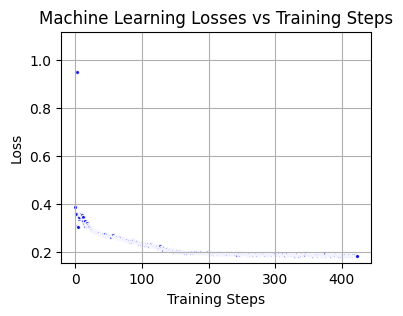

In [157]:
fig = plot_losses_vs_steps(losses)
plt.show()

In [158]:
from scipy.special import gammaln

K = psm.dimensionality
log_ball_vol = (K / 2) * np.log(np.pi) - gammaln(K / 2 + 1)
def log_p_ball(values):
    return torch.full(values.shape[:-1], -log_ball_vol, dtype=values.dtype, device=values.device)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
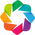

In [159]:
import holoviews as hv 
hv.extension('bokeh')

In [160]:
wrapped_vf = WrappedModel(ball_model)
n_test = 5000
x_init = sample_ball((n_test, K))
solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class

In [161]:
sol, log_det = riem_sample_and_div(
    riem_solver=solver,
    xt_batch_size=5000,
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates=False,
    return_div=True,
    exact_divergence=True,
)

In [162]:
# pickle.dump((sol, log_det), open('ball_flow_sols_log_dets2.p', 'wb'))
# sol, log_det = pickle.load(open('ball_flow_sols_log_dets.p', 'rb'))


In [163]:
# from torch.autograd.functional import jacobian

In [178]:
f = lambda x: map_ball_2_rounded(psm, x, sep_radius=False, jacobian=False)
jacobian(f, sol[0].to(device='cpu', dtype=torch.double))

tensor([[[ 3.6225, -0.5073, -0.0634, -0.3115],
         [-0.3770,  1.0014,  0.0089,  0.0436],
         [-0.0471,  0.0089,  0.9315,  0.0054],
         [-0.2315,  0.0436,  0.0054,  0.9571]]], dtype=torch.float64)

In [179]:
J_rb[0]

tensor([[ 2.5199e-01, -3.5288e-02, -4.4070e-03, -2.1668e-02],
        [ 9.4994e-02,  9.3530e-01,  6.1713e-04,  3.0343e-03],
        [ 1.1864e-02,  6.1713e-04,  9.3044e-01,  3.7894e-04],
        [ 5.8330e-02,  3.0343e-03,  3.7894e-04,  9.3222e-01]],
       dtype=torch.float64)

In [166]:
ball_flow_rounded, J_rb = map_ball_2_rounded(psm, ball=sol.to(device='cpu', dtype=torch.double), alpha_root=K, sep_radius=False, jacobian=True)

log_abs_dets_J = torch.log(abs(fcm._la.det(J_rb)))  # log abs det of Jacobian from ball to rounded
log_q0 = log_p_ball(x_init).to('cpu')
log_q = log_q0 - abs(log_det).to('cpu') - log_abs_dets_J 
flow_numpy = sol.to(device='cpu', dtype=torch.double)

In [167]:
in_pol = ((psm._G @ flow_numpy.T) < psm._h).all(0)
in_pol = in_pol.sum()

log_pol_vol = torch.log(torch.as_tensor(pol_volume, dtype=torch.float))
log_p = mog_target.log_prob(ball_flow_rounded.to(device='cpu')) - log_pol_vol

diff = log_p - log_q
ws = torch.exp(diff)
KL_Z = ws.mean()
ln_KL = (log_p + log_q).mean() + np.log(KL_Z)
KL = np.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()
print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {round(KL.item(), 8)}, in pol: {in_pol}')

ESS: 0.271, KL div.: 0.00167316, in pol: 5000


In [168]:
(hv.Scatter((diff.numpy(), log_p.to('cpu').numpy())) + hv.Scatter((r, log_p.to('cpu').numpy()))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [171]:
(hv.Scatter((diff.numpy(), log_q.to('cpu').numpy())) + hv.Scatter((r, log_q.to('cpu').numpy()))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [172]:
(hv.Scatter((diff.numpy(), log_q.to('cpu').numpy())) + hv.Scatter((r, log_q.to('cpu').numpy()))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [173]:
(hv.Scatter((diff.numpy(), log_abs_dets_J.to('cpu').numpy())) + hv.Scatter((r, log_abs_dets_J.to('cpu').numpy()))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [174]:
(hv.Scatter((diff.numpy(), log_det.to('cpu').numpy())) + hv.Scatter((r, log_det.to('cpu').numpy()))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [175]:
log_q0

tensor([-1.5963, -1.5963, -1.5963,  ..., -1.5963, -1.5963, -1.5963])

In [176]:
ding = log_det.to('cpu').numpy() + log_abs_dets_J.to('cpu').numpy()
(hv.Scatter((ws.numpy(), ding)) + hv.Scatter((r, ding))).opts(shared_axes=False)

:Layout
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [177]:
r = sol.to(device='cpu', dtype=torch.double).norm(2, -1).numpy()

hv.Scatter((ws.numpy(), r))

:Scatter   [x]   (y)

In [117]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=pd.DataFrame(ball_flow_rounded, columns=fcm.sampler.rounded_id),
    n_sample_cdf=10000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

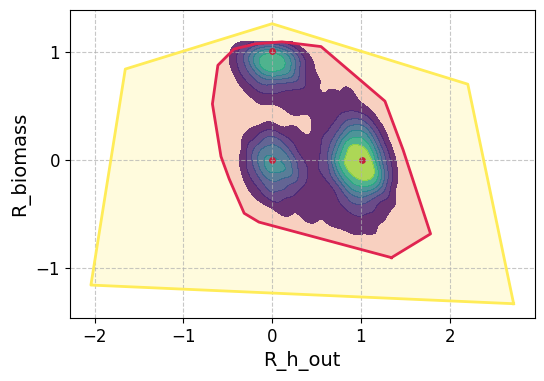

In [118]:
plt.show()

In [60]:
# plt.savefig(
#     'ball_flow.svg', transparent=None, dpi='figure', format='svg',
#     metadata=None, bbox_inches=None, pad_inches=0.1,
#     facecolor='auto', edgecolor='auto', backend=None,
# )